In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco
sns.set()

In [2]:
tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']
etf=yf.Tickers(tickers)
data = etf.history(start='2011-01-01',actions=False)
data = data.drop(['Open','High','Low','Volume'],axis=1)
data = data.droplevel(0,axis=1)

[*********************100%***********************]  9 of 9 completed


In [7]:
# 수익률
rets = data.pct_change().fillna(0)
# 수익률 벡터
er = rets.mean() * 252
# 공분산 행렬
cov = rets.cov() * 252

# 샤프비율 최대화 포트폴리오

In [13]:
# 샤프비율 최대화 포트폴리오 가중치 산출 함수 구현
def get_msr_weights(er, cov):
    # 자산 개수
    noa = er.shape[0]
    
    # 가중치 초기값
    init_guess = np.repeat(1/noa, noa)
    
    # 자산 가중치 상하한
    bounds = ((0.0, 1.0),) * noa
    
    # 레버리지 불가 제약조건
    weights_sum_to_1 = {'type': 'eq',
                       'fun': lambda weights: np.sum(weights) - 1}
    
    # 목적함수
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er # @:행렬곱
        vol = np.sqrt(weights.T @ cov @ weights)
        return  - r / vol
    
    res = sco.minimize(neg_sharpe,
                          init_guess,
                          args=(er,cov),
                          method='SLSQP',
                          bounds=bounds,
                          constraints=(weights_sum_to_1,))
    return res.x

In [15]:
msr_weights = get_msr_weights(er,cov)

msr_ret = np.dot(msr_weights, er)

msr_vol = np.sqrt(np.dot(msr_weights.T, np.dot(cov, msr_weights)))

print(f'Return = {msr_ret}')
print(f'Volatility = {msr_vol}')

Return = 0.1430843577246568
Volatility = 0.15252627889032114


<AxesSubplot: >

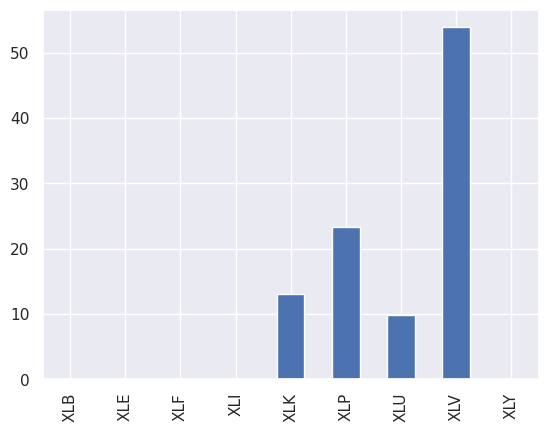

In [16]:
msr_weights_series = pd.Series(np.round(msr_weights,4)*100, index = tickers)
msr_weights_series.plot.bar()

# 자본시장선 구현

In [20]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(er * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return np.array([pret, pvol, pret/pvol])

def obj_func(weights):
    return statistics(weights)[1]

In [21]:
noa = len(tickers)

trets = np.linspace(0.1, 0.15, 50)
tvols = []

for tret in trets:
    # 가중치 초기값
    ini_guess = np.repeat(1/noa, noa)
    # 제약조건
    cons= ({'type':'eq', 'fun':lambda x : statistics(x)[0] - tret},
          {'type':'eq', 'fun':lambda x : np.sum(x) - 1})
    # 자산 가중치 상하한
    bnds = ((0.0, 1.0),)*noa
    
    res = sco.minimize(obj_func,
                      ini_guess,
                      method='SLSQP',
                      bounds=bnds,
                      constraints=cons)
    tvols.append(res['fun'])
 

tvols=np.array(tvols)
    
    

In [22]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [23]:
evols[-1]

0.1607720959489065

Text(0.5, 1.0, 'Market Portfolio & Capital Market Line')

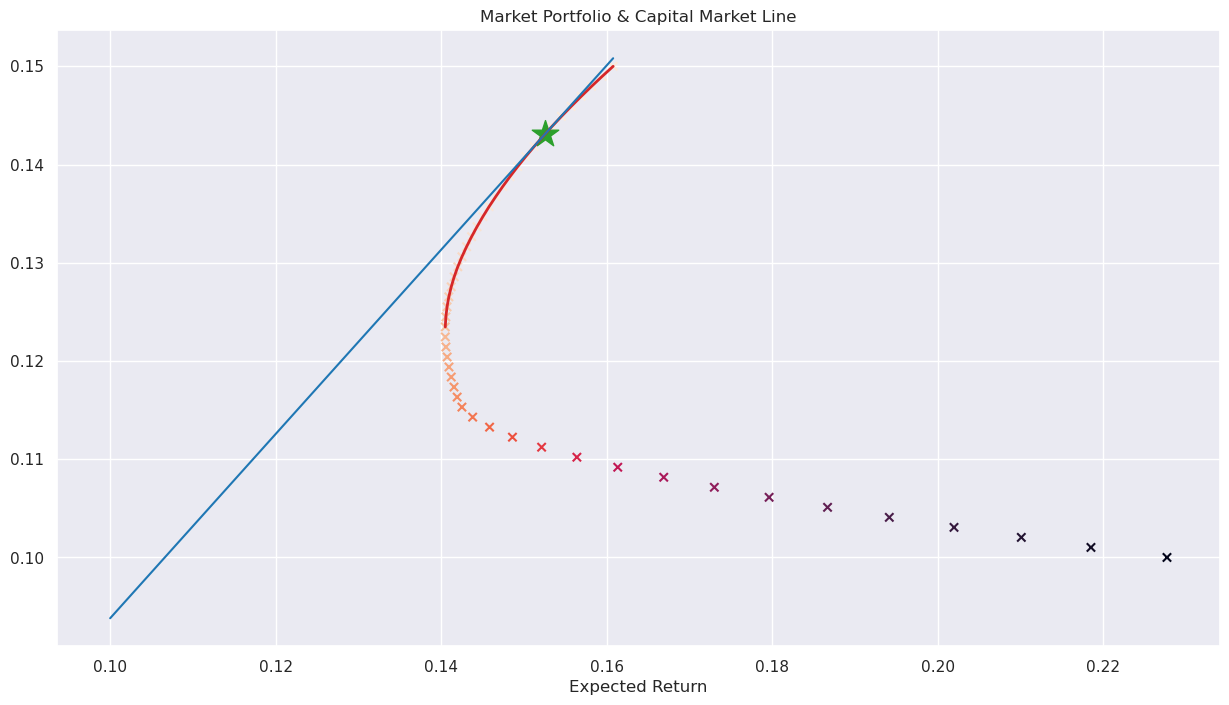

In [24]:
# 자본시장선 데이터
x = np.linspace(0.1, evols[-1], 100)
y = (msr_ret/msr_vol)*x

# 효율적 경계선 및 자본시장선 시각화
plt.figure(figsize=(15,8))

plt.scatter(tvols, trets, c=trets/tvols, marker='x')
plt.plot(evols, erets, 'tab:red', lw=2.0)

#시장 포트폴리오
plt.scatter(msr_vol, msr_ret, marker='*', s=400, color='tab:green')

#자본시장선
plt.plot(x,y, 'tab:blue')

plt.grid(True)
plt.xlabel('Expected Volatility')
plt.xlabel('Expected Return')

plt.title('Market Portfolio & Capital Market Line')